In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
warnings.simplefilter('ignore')

In [2]:
from bs4 import BeautifulSoup as bs
# import requests
import urllib
from urllib.request import urlopen, Request

## Rosbank ML Competition

In [3]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [5]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [6]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [7]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  393211
Total transactions in test dataset:  97302


## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

## Практика

# EDA

In [8]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


Посмотрим на распределение транзакций по mcc кодам

In [10]:
raw_df['MCC'].value_counts().head()

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
Name: MCC, dtype: int64

In [11]:
mcc_data_0 = raw_df[raw_df['target_flag'] == 0][['MCC','amount']].groupby(['MCC'])['amount'].size()
mcc_data_0 = pd.DataFrame(mcc_data_0)
mcc_data_0.head()

,amount
MCC,
742,10
763,11
780,3
1520,10
1711,18


In [12]:
mcc_data_0.sort_values(by='amount',ascending=False).astype('int').head()

,amount
MCC,
5411,46297
6011,18858
5814,11066
5499,9324
5812,8286


Скачаем расшифровку mcc кодов, чтобы удобнее было анализировать

In [13]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'
}
reg_url = 'https://mcc-codes.ru/code'
req = Request(url=reg_url, headers=headers)
check = bs(urlopen(req).read())
list_of_mcc_tags = check.find_all('tr')[1:]
mcc_names_list = list(
    map(
        lambda x: (x.text.split('\n')[1], x.text.split('\n')[2]), list_of_mcc_tags
    )
)

In [14]:
mcc = pd.DataFrame(mcc_names_list)
mcc.head()
mcc.columns = ['code','name']
mcc['code'] = mcc['code'].astype('int')

In [15]:
mcc_data_merged_0 = mcc_data_0.merge(mcc,left_on = 'MCC',right_on='code',how='inner')
mcc_data_merged_0.head()

,amount,code,name
0,10,742,Ветеринарные услуги
1,11,763,Сельскохозяйственные кооперативы
2,3,780,Услуги садоводства и ландшафтного дизайна
3,10,1520,Генеральные подрядчики – жилое и коммерческое ...
4,18,1711,"Генеральные подрядчики по вентиляции, теплосна..."


In [16]:
mcc_data_merged_0.sort_values(by='amount',ascending=False).head(25)

,amount,code,name
114,46297,5411,"Бакалейные магазины, супермаркеты"
194,18858,6011,Финансовые учреждения – снятие наличности авто...
153,11066,5814,Фастфуд
119,9324,5499,Различные продовольственные магазины - нигде б...
151,8286,5812,"Места общественного питания, рестораны"
124,7200,5541,"Станции техобслуживания, с дополнительными усл..."
158,6752,5912,Аптеки
195,4347,6012,Финансовые учреждения – торговля и услуги
192,3902,5999,Различные магазины и специальные розничные маг...
159,2808,5921,Магазины с продажей спиртных напитков навынос


In [17]:
mcc_data = raw_df[raw_df['target_flag'] == 1][['MCC','amount']].groupby(['MCC'])['amount'].size()

In [18]:
mcc_data_left = pd.DataFrame(mcc_data.sort_values(ascending=False))
mcc_data_left.merge(mcc,left_on = 'MCC',right_on='code',how='inner').head(25)

,amount,code,name
0,75343,5411,"Бакалейные магазины, супермаркеты"
1,35524,6011,Финансовые учреждения – снятие наличности авто...
2,30285,5814,Фастфуд
3,21741,5812,"Места общественного питания, рестораны"
4,17913,5499,Различные продовольственные магазины - нигде б...
5,12616,5541,"Станции техобслуживания, с дополнительными усл..."
6,11976,5912,Аптеки
7,9171,5999,Различные магазины и специальные розничные маг...
8,5770,5921,Магазины с продажей спиртных напитков навынос
9,5709,6012,Финансовые учреждения – торговля и услуги


Для тех, у кого target_flag = 1 и target_flag = 0 первые по популярности mcc коды практически одинаковы. Для пользователей с 0, есть категории садовые принадлежности и товары для дома, для пользователей с target_flag 1 таких категорий нет, вместо них амгазины с одеждой, лимузины и такси. Складывается впечатление, что группа пользователей с 0 более возрастная, так как затраты скорее связаны с домом, семьей, меньше трат на проезд или траты на проезд стоят на более низких позициях. Возможно категория с 1 - более мобильные граждане, часто бывающие вне дома.

Посмотрим на распределение суммы транзакций по дням недели

In [26]:
raw_df.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'target_flag', 'target_sum'],
      dtype='object')

In [34]:
raw_df['day_of_transaction'] = raw_df['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%a')
    ) 

In [35]:
day_data_0 = raw_df[raw_df['target_flag']==0][['day_of_transaction','amount']].groupby('day_of_transaction')['amount'].agg([np.sum]).astype('int')

In [36]:
day_data_0

,sum
day_of_transaction,
Fri,181280749
Mon,155052797
Sat,108147929
Sun,82076408
Thu,177493952
Tue,164744012
Wed,166579601


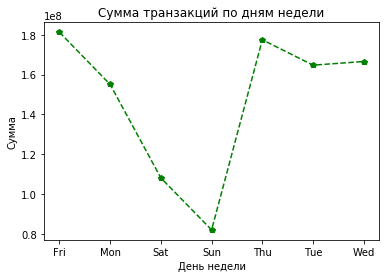

In [37]:
x = np.arange(1,8,1)
plt.plot(x,day_data_0['sum'],marker='p',linestyle='dashed',color='g')
plt.xticks(x,day_data_0.index)
plt.title('Сумма транзакций по дням недели')
plt.xlabel('День недели')
plt.ylabel('Сумма');

Можем видеть, что больше всего транзакций происходит в пятницу,а меньше всего - в воскресенье.

In [38]:
day_data = raw_df[raw_df['target_flag']==1][['day_of_transaction','amount']].groupby(['day_of_transaction'])['amount'].agg([np.sum]).astype('int')

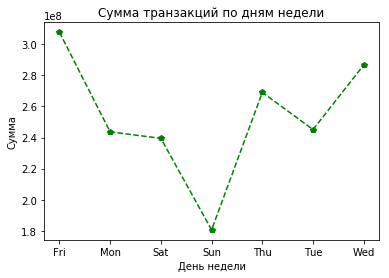

In [39]:
x = np.arange(1,8,1)
plt.plot(x,day_data['sum'],marker='p',linestyle='dashed',color='g')
plt.xticks(x,day_data.index)
plt.title('Сумма транзакций по дням недели')
plt.xlabel('День недели')
plt.ylabel('Сумма');

Среди тех, кто перестал пользоваться продуктом, ситуация практически аналогичная, единственно, транзакция в субботу такие люди совершаю больше, практически на уровне с пн.

Сравним траты по дням недели в пределах двух групп на одном графике.

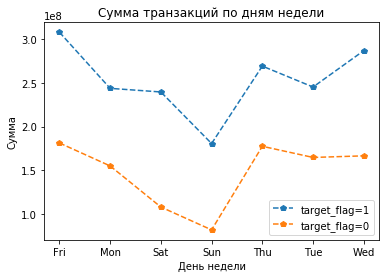

In [40]:
x = np.arange(1,8,1)
plt.plot(x,day_data['sum'],marker='p',linestyle='dashed',label='target_flag=1')
plt.plot(x,day_data_0['sum'],marker='p',linestyle='dashed',label='target_flag=0')
plt.xticks(x,day_data.index)
plt.title('Сумма транзакций по дням недели')
plt.xlabel('День недели')
plt.ylabel('Сумма')
plt.legend(loc='best');

Можем видеть, что наша целевая группа в целом по всем дням недели тратит больше пользователей, которые продолжают пользоваться продуктом. ФОрма ломаной линии трат примерно одинакова, различия заметны по субботе, для целевой группы они выше. Опять же,
как уже говорилось выше, можно предположить, что группа пользователей с 1 более молодая, так как повышенные траты в субботу говорят возможно о тратах на развлечения, походыв клубы и рестораны. Однако, то, что траты группы с 1 больше, говорит скорее против этой теории, обычно считается, что молодежь менее состоятельна, чем взрослые люди. Можно сказать точно только следующее - группа с 1 более состоятельнее группы 0. То есть, перестают пользоваться продуктом скорее более состоятельные люди.

Посмотрим на распределение категорий

In [41]:
cat_data_0 = raw_df[raw_df['target_flag'] == 0][['trx_category','amount']].groupby(['trx_category'])['amount'].agg([np.sum]).astype('int')

In [42]:
cat_data_0.sort_values(by='sum',ascending=False).head(10)

,sum
trx_category,
POS,302447952
WD_ATM_ROS,264459850
DEPOSIT,205916278
WD_ATM_PARTNER,164271300
C2C_IN,43592868
C2C_OUT,30926064
BACK_TRX,10956092
WD_ATM_OTHER,6468331
CAT,5811950


In [43]:
cat_data_1 = raw_df[raw_df['target_flag'] == 1][['trx_category','amount']].groupby(['trx_category'])['amount'].agg([np.sum]).astype('int')

In [44]:
cat_data_1.sort_values(by='sum',ascending=False).head(10)

,sum
trx_category,
POS,710613885
WD_ATM_ROS,403624650
DEPOSIT,276829617
WD_ATM_PARTNER,168446450
WD_ATM_OTHER,68312289
C2C_OUT,57148814
C2C_IN,56304281
CAT,16790909
BACK_TRX,13663080


In [45]:
cat_data_cnt_0 = raw_df[raw_df['target_flag'] == 0][['trx_category','amount']].groupby(['trx_category'])['amount'].agg(['count']).astype('int')

In [47]:
cat_data_cnt_0.sort_values(by='count',ascending=False).head(10)

,count
trx_category,
POS,143428
DEPOSIT,11316
WD_ATM_ROS,5496
C2C_IN,3341
WD_ATM_PARTNER,2853
C2C_OUT,1786
BACK_TRX,1103
WD_ATM_OTHER,771
CAT,300


In [48]:
cat_data_cnt_1 = raw_df[raw_df['target_flag'] == 1][['trx_category','amount']].groupby(['trx_category'])['amount'].agg(['count']).astype('int')

In [49]:
cat_data_cnt_1.sort_values(by='count',ascending=False).head(10)

,count
trx_category,
POS,272997
WD_ATM_ROS,13608
DEPOSIT,9900
WD_ATM_PARTNER,7095
WD_ATM_OTHER,6369
C2C_IN,3965
C2C_OUT,3670
BACK_TRX,1584
CAT,897


По суммам транзакций паттерны среди двух групп практически одинаковые. Однако, по количеству транзакций, среди групп есть различия. Группа с 0 (лояльные) на втором месте по количеству имеет DEPOSIT, нелояльные - WD_ATM_ROS, и вообще, все транзакции через банкоматы Росбанка и через банкоматы других банков у группы нелояльных пользователей нахоятся выше в списпе.Можно предположить, что нелояльные группы пользователей больше пользуются наличными деньгами, в то время как лояльные - больше переводят с карты на карту.

Посмотрим на распределение транзакций по часам

In [50]:
def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    return dataset.groupby(['cl_id','hour_of_transaction'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [51]:
hours_0 = raw_df[raw_df['target_flag'] == 0][['amount','TRDATETIME','target_flag']].copy()

In [296]:
hours_0['hour'] = hours_0['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') )

In [164]:
hours_0.head()

,amount,TRDATETIME,target_flag,hour
0,5023.0,21OCT17:00:00:00,0,00
1,20000.0,12OCT17:12:24:07,0,12
2,767.0,05DEC17:00:00:00,0,00
3,2031.0,21OCT17:00:00:00,0,00
4,36562.0,24OCT17:13:14:24,0,13


In [293]:
hours_merged_0 = hours_0.groupby('hour')['amount'].agg([np.sum]).astype('int')
hours_merged_0

,sum
hour,
00,505765875
01,1534678
02,2660844
03,3435890
04,5109868
05,8951929
06,12105498
07,14807407
08,22380092


In [294]:
hours_1 = raw_df[raw_df['target_flag'] == 1][['amount','TRDATETIME','target_flag']].copy()
hours_1['hour'] = hours_1['TRDATETIME'].apply(lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') )
hours_merged_1 = hours_1.groupby('hour')['amount'].agg([np.sum]).astype('int')

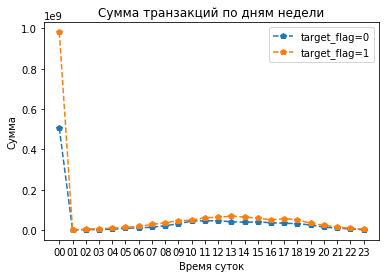

In [301]:
x = np.arange(1,25,1)
plt.plot(x,hours_merged_0['sum'],marker='p',linestyle='dashed',label='target_flag=0')
plt.plot(x,hours_merged_1['sum'],marker='p',linestyle='dashed',label='target_flag=1')
plt.xticks(x,hours_merged.index)
plt.title('Сумма транзакций по дням недели')
plt.xlabel('Время суток')
plt.ylabel('Сумма')
plt.legend(loc='best');

Опять же можем видеть, что группа с 1 тратит больше, в 00 часов траты начительно выше, скорее всего,это те самые POS операции, о которых уже говорилось выше. То есть, тратит через POS терминалы группа с 1 гораздо выше. Также повышены траты в обеденное время, возможно в это время деньги идут на обед в столовых , кафе, ресторанах, если это так, то можем видеть, что тратит на обед группа с 1 больше.

Посмотрим на совместное распределение признаков в разресе категории в табличном виде:

In [159]:
pd.crosstab(raw_df['target_flag'],raw_df['trx_category'],normalize=True)

trx_category,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS
target_flag,,,,,,,,,,
0,0.002249,0.006811,0.003641,0.000033,0.000612,0.023070,0.292404,0.001572,0.005816,0.011205
1,0.003229,0.008083,0.007482,0.000037,0.001829,0.020183,0.556554,0.012984,0.014464,0.027742


# Feauture engeneering

In [338]:
raw_df.drop('target_sum', axis=1).head()
print(len(df_merged))

490513


Идея: сгенерируем для каждого cl_id+channel_type+target_flag отдельные временные датасеты с общей суммой и количеством транзакций на клиента, суммой транзакций по валютам, суммой транзакций по MCC, суммой транзакций по категориям, суммой транзакций по часам, суммой транзакций по дням недели. Затем сдоиним получившиеся датасеты в один.

##### Средняя сумма транзакций на клиента и количество

In [52]:
def get_transaction_by_client(df):
    temp_df = raw_df[['cl_id','amount']].groupby('cl_id')['amount'].aggregate([np.mean, np.size]).reset_index().set_index('cl_id')
    temp_df['size'] = temp_df['size'].astype('int')
    temp_df.rename(columns={'size' : 'total_tr_count', 'mean' : 'total_tr_mean'},inplace=True)
    return temp_df
tr_per_cl = get_transaction_by_client(raw_df)
print(len(tr_per_cl))

5000


##### Среднее и количество транзакций на клиента по основным MCC-кодам

Возьмем N наиболее популярных MCC кодов

In [54]:
mcc_list = raw_df['MCC'].value_counts(dropna=False).reset_index().head(10)['index'].tolist()
mcc_list

[5411, 6011, 5814, 5812, 5499, 5541, 5912, 5999, 6012, 5921]

In [55]:
#Все mcc, которые не входят в список популярных, будем обозначать как 0 (прочее)
def transaction_per_mcc(data):
    temp_df = data[['cl_id','target_flag','channel_type','MCC','amount']]
    temp_df['MCC'] = temp_df['MCC'].apply(lambda x: x if x in  mcc_list else 0)
    temp_df = temp_df.groupby(['cl_id','MCC'])['amount'].agg([np.mean,'count']).unstack().fillna(0).astype('int')   
    temp_df.columns = ['_'.join(('mcc',str(x[1]),x[0])) for x in temp_df.columns.ravel()]
    return temp_df
mcc_per_cl = transaction_per_mcc(raw_df)
print(len(mcc_per_cl))

5000


In [56]:
#example
raw_df_grouped = raw_df[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])

# aggregated_dataset = raw_df_grouped.unstack().fillna(0)


##### Транзакции на клиента по trx_category

In [57]:
raw_df['trx_category'].value_counts()

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64

In [58]:
def transaction_per_trx_category(data):
    temp_df = data[['cl_id','trx_category','amount']]
    temp_df = temp_df.groupby(['cl_id','trx_category'])['amount'].agg([np.mean,'count']).unstack().fillna(0).astype('int')
    temp_df.columns = ["_".join(x) for x in temp_df.columns.ravel()]
    #another way to get rid of multilevel index by dropping it temp_df.columns = temp_df.columns.drop_level(0)
    return temp_df
cat_pr_cl = transaction_per_trx_category(raw_df)
print(len(cat_pr_cl))

5000


##### Транзакции по основным видам валют

In [59]:
cur_lst = raw_df['currency'].value_counts(dropna=False).reset_index().head(5)['index'].tolist()

In [60]:
def transaction_per_cur(data):  
    temp_df = data[['cl_id','currency','amount']]
    temp_df['currency'] = temp_df['currency'].apply(lambda x: x if x in  cur_lst else 0)
    temp_df = temp_df.groupby(['cl_id','currency'])['amount'].agg([np.mean,'count']).unstack().fillna(0).astype('int')   
    temp_df.columns = ['_'.join(('cur',str(x[1]),x[0])) for x in temp_df.columns.ravel()]
    return temp_df
cur_per_cl = transaction_per_cur(raw_df)
print(len(cur_per_cl))

5000


##### Транзакции по дням недели

In [61]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%a')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index().set_index('cl_id').astype('int')
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_cnt_' + old_col for old_col in old_columns},
        inplace=True
    )
    #Избавляемся от остатков названий колонки: day_of_transaction(будет висеть в левом углу, если не удалить)
    tmp_df.columns.name = None
    tmp_df['total_cnt_per_wknd'] = tmp_df['day_cnt_Fri']+tmp_df['day_cnt_Sat']+tmp_df['day_cnt_Sun']
    tmp_df['total_cnt_per_work_days'] = tmp_df[[col for col in tmp_df.columns.tolist() if col not in ['day_cnt_Fri','day_cnt_Sat','day_cnt_Sun','total_cnt_per_wknd']]].sum(axis=1)
    tmp_df.drop([col for col in tmp_df.columns.tolist() if col not in ['total_cnt_per_wknd','total_cnt_per_work_days']], axis=1,inplace=True)
    return tmp_df
    

wekday_per_cl = transaction_by_day_count(raw_df)
print(len(wekday_per_cl))

5000


In [62]:
def transaction_by_day_sum(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%a')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['amount'].sum().unstack().fillna(0).reset_index().set_index('cl_id')
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_cnt_' + old_col for old_col in old_columns},
        inplace=True
    )
    #Избавляемся от остатков названий колонки: day_of_transaction(будет висеть в левом углу, если не удалить)
    tmp_df.columns.name = None
    tmp_df['total_sum_per_wknd'] = tmp_df['day_cnt_Fri']+tmp_df['day_cnt_Sat']+tmp_df['day_cnt_Sun']
    tmp_df['total_sum_per_work_days'] = tmp_df[[col for col in tmp_df.columns.tolist() if col not in ['day_cnt_Fri','day_cnt_Sat','day_cnt_Sun','total_cnt_per_wknd']]].sum(axis=1)
    tmp_df.drop([col for col in tmp_df.columns.tolist() if col not in ['total_sum_per_wknd','total_sum_per_work_days']], axis=1,inplace=True)
    return tmp_df
    

wekdaysum_per_cl = transaction_by_day_sum(raw_df)
print(len(wekdaysum_per_cl))

5000


##### Транзакции по частям дня

In [63]:

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    temp = dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index().astype('int').set_index('cl_id')
    temp.columns.name = None
    temp.rename(
        columns={col: 'hour_' + col for col in temp.columns.tolist()},
        inplace=True
    )
    night_hours = [x for x in temp.columns.tolist() if int(x[-2:]) < 6]
    morn_hours = [x for x in temp.columns.tolist() if int(x[-2:]) >= 6 and int(x[-2:]) < 12]
    day_hours = [x for x in temp.columns.tolist() if int(x[-2:]) >= 12 and int(x[-2:]) < 18]
    evn_hours = [x for x in temp.columns.tolist() if int(x[-2:]) >= 18 and int(x[-2:]) <= 23]
    temp['tr_per_night_hours'] = temp[night_hours].sum(axis=1)
    temp['tr_per_morn_hours'] = temp[morn_hours].sum(axis=1)
    temp['tr_per_evn_hours'] = temp[evn_hours].sum(axis=1)
    temp['tr_per_day_hours'] = temp[day_hours].sum(axis=1)
    
    temp.drop([col for col in temp.columns.tolist() if col not in ['tr_per_morn_hours','tr_per_evn_hours','tr_per_day_hours','tr_per_night_hours']], axis=1,inplace=True)
    return temp
day_per_cl = transaction_by_hour_count(raw_df)
print(len(day_per_cl))

5000


Небольшое пояснение, почему в ночные часы так много транзакций. В хоед анализа было установлено, что ночные часы уходя в отрыв в основном засчет часа 00. В этот момент больше всего совершается POS-транзакций, которые относятся POINT OF SALE - когда покупка совершается через терминал, потом информация о ней отправляется в банк, где скорее всего, все такие транзакции обрабатываются в совокупности в 00 часов.

##### Изменение количества транзакций по периодам

Здесь попытаемся отобразить следуещее. Посчитаем процентное отношение количества транзакций в текущем к месяце, к прошлому месяцу. Так для всех месяцев периода. Чтобы рассматривать только относительно недванее поведение пользователя, будем брать изменения за 8 месяцев. Далее, считаем чего больше, количество негативных изменений или позитивных. Если позитивных, ставим 1, иначе - 0.

In [64]:
def get_prcn_chng_per_cl(data):
    data['PERIOD'] = pd.to_datetime(data['PERIOD'])
    temp =  data.groupby(['cl_id','PERIOD'])['cl_id'].size().unstack().fillna(0).astype('int').pct_change(periods=8,axis='columns',fill_method='ffill').fillna(0).replace(np.inf, 0).reset_index()
    temp['positive_chng'] =  temp.apply(lambda x: int(len([z for z in x if z < 0]) < len([z for z in x if z > 0])), axis=1)
    temp = temp.set_index('cl_id')
    temp.columns.name = None
    temp = temp[['positive_chng']]
    return temp
p_per_cl =  get_prcn_chng_per_cl(raw_df)
print(len(p_per_cl))

5000


Соединим полученные датасеты в один

In [65]:
from  functools import reduce
list_dfs = [tr_per_cl,mcc_per_cl,cat_pr_cl,cur_per_cl,wekday_per_cl,wekdaysum_per_cl,day_per_cl,p_per_cl]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['cl_id'],
                                            how='inner'), list_dfs)
print(len(df_merged))

5000


Оставим отдельно train и test

In [66]:
raw_df_m = raw_df[['cl_id','target_flag']].drop_duplicates()
print(len(raw_df_m ))

5000


In [67]:
df_merged = df_merged.merge(raw_df_m,right_on='cl_id', left_on='cl_id',how='inner')
print("Total transactions in train dataset: ", len(df_merged))

Total transactions in train dataset:  5000


In [68]:
print(len(df_merged))

5000


In [71]:
df_merged.head()

,cl_id,total_tr_mean,total_tr_count,mcc_0_mean,mcc_5411_mean,mcc_5499_mean,mcc_5541_mean,mcc_5812_mean,mcc_5814_mean,mcc_5912_mean,...,total_cnt_per_wknd,total_cnt_per_work_days,total_sum_per_wknd,total_sum_per_work_days,tr_per_night_hours,tr_per_morn_hours,tr_per_evn_hours,tr_per_day_hours,positive_chng,target_flag
0,0,12876.600000,5,5023,2031,0,0,0,0,0,...,2,3,7054.00,64383.00,3,0,0,2,0,0
1,1,2572.865769,104,813,1219,246,0,167,2010,813,...,32,72,189804.37,267578.04,101,0,3,0,0,0
2,5,3847.669930,142,3742,1449,899,0,1654,247,601,...,64,78,194549.40,546369.13,124,2,7,9,0,1
3,9,21777.310000,39,420,39,0,0,0,0,0,...,13,26,90406.09,849315.09,15,8,7,9,0,0
4,10,2428.388747,463,866,523,440,716,159,502,648,...,233,230,855855.34,1124343.99,339,72,1,51,0,0


In [73]:
y = df_merged['target_flag']
x = df_merged.drop('target_flag',axis=1)
x.head()

,cl_id,total_tr_mean,total_tr_count,mcc_0_mean,mcc_5411_mean,mcc_5499_mean,mcc_5541_mean,mcc_5812_mean,mcc_5814_mean,mcc_5912_mean,...,cur_985_count,total_cnt_per_wknd,total_cnt_per_work_days,total_sum_per_wknd,total_sum_per_work_days,tr_per_night_hours,tr_per_morn_hours,tr_per_evn_hours,tr_per_day_hours,positive_chng
0,0,12876.600000,5,5023,2031,0,0,0,0,0,...,0,2,3,7054.00,64383.00,3,0,0,2,0
1,1,2572.865769,104,813,1219,246,0,167,2010,813,...,0,32,72,189804.37,267578.04,101,0,3,0,0
2,5,3847.669930,142,3742,1449,899,0,1654,247,601,...,0,64,78,194549.40,546369.13,124,2,7,9,0
3,9,21777.310000,39,420,39,0,0,0,0,0,...,0,13,26,90406.09,849315.09,15,8,7,9,0
4,10,2428.388747,463,866,523,440,716,159,502,648,...,0,233,230,855855.34,1124343.99,339,72,1,51,0


# Model

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

Сначала построим модель логистической регрессии. Так как признаков много, не факт, что все из них важны + признаки достаточно разного масштаба,используем l1 регуляризацию и предварительно отмасштабируем данные для логистической регрессии.

In [75]:
clf = LogisticRegression(penalty='l1')
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=0,stratify=y)
X_train = scaler.fit_transform(X_train)

In [76]:
clf.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.8


AUC дает достаточно неплохой результат

In [78]:
X_test = scaler.transform(X_test)
print('Правильность на тренировочном наборе {:.2f}'.format(clf.score(X_train,y_train)))
print('Правильность на тестовом наборе {:.2f}'.format(clf.score(X_test,y_test)))

Правильность на тренировочном наборе 0.73
Правильность на тестовом наборе 0.74


Полученная точность на тестовом наборе выше обучающего, что говорит, что наша модель обладает в том числе и способностью к обобщению, однако сами оценки маленькие и разница между обучающим и тестовым - невилика. Скорее всего, мы недообучили модель.

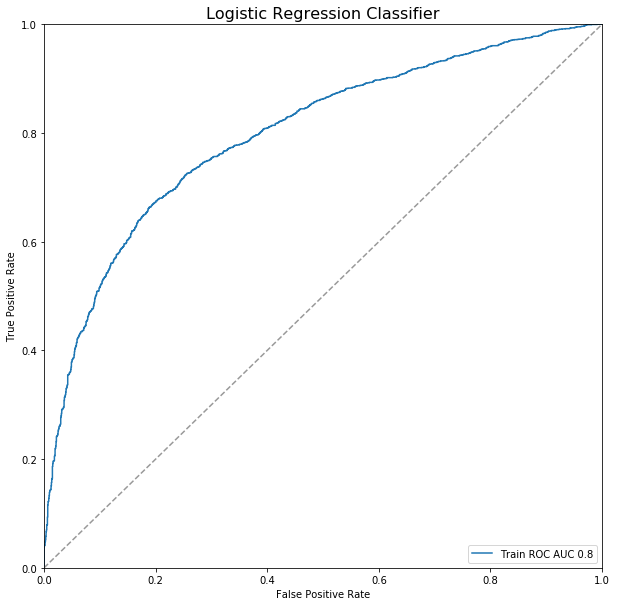

In [79]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [80]:
y_test_predict = clf.predict_proba(X_test)[:, 1]

Выведем предсказания для тестового набора. Показывает вероятность того, что человек перестанет пользоваться продуктом.

In [81]:
y_test_predict

array([0.44298817, 0.89044718, 0.76321081, ..., 0.15416631, 0.36941275,
       0.17403356])

Так как логистическая регрессия дала достаточно невысокий результат, попробуем использоватьклассификационные алгоритмы на основе дерева. Такие алгоритмы не требуют мосштабирования, однако сильнее переобучаются и требуют больше ресурсов.

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [95]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0)
tree.fit(X_train,y_train)
print('Правильность на тренировочном наборе {:.2f}'.format(tree.score(X_train,y_train)))
print('Правильность на тестовом наборе {:.2f}'.format(tree.score(X_test,y_test)))

Правильность на тренировочном наборе 0.74
Правильность на тестовом наборе 0.73


Точность даже хуже, чем в случае логистической регрессии. Попробуем посмотреть, на важность признаков.

In [84]:
for name,score in zip(x.columns,tree.feature_importances_):
    print(name,score)

cl_id 0.6145057130886905
total_tr_mean 0.014575955624574543
total_tr_count 0.0
mcc_0_mean 0.013574871729848998
mcc_5411_mean 0.0227274989102714
mcc_5499_mean 0.0
mcc_5541_mean 0.0
mcc_5812_mean 0.0
mcc_5814_mean 0.0
mcc_5912_mean 0.0
mcc_5921_mean 0.0
mcc_5999_mean 0.0
mcc_6011_mean 0.0
mcc_6012_mean 0.0
mcc_0_count 0.0
mcc_5411_count 0.0
mcc_5499_count 0.0
mcc_5541_count 0.0
mcc_5812_count 0.0
mcc_5814_count 0.0
mcc_5912_count 0.0
mcc_5921_count 0.0
mcc_5999_count 0.0
mcc_6011_count 0.0
mcc_6012_count 0.004488312597003482
mean_BACK_TRX 0.0
mean_C2C_IN 0.0
mean_C2C_OUT 0.0068389033669661705
mean_CASH_ADV 0.0
mean_CAT 0.0
mean_DEPOSIT 0.02461944601193776
mean_POS 0.0
mean_WD_ATM_OTHER 0.008820247631575847
mean_WD_ATM_PARTNER 0.0
mean_WD_ATM_ROS 0.0
count_BACK_TRX 0.0
count_C2C_IN 0.0
count_C2C_OUT 0.0
count_CASH_ADV 0.0
count_CAT 0.0
count_DEPOSIT 0.0
count_POS 0.09647396430978354
count_WD_ATM_OTHER 0.0
count_WD_ATM_PARTNER 0.0
count_WD_ATM_ROS 0.0
cur_0_mean 0.0
cur_810_mean 0.0
cur_84

Можем видеть, что из каждой группы признаков выделились те, которые наиболее значимы для нашей модели. Как и ожидалось, многие из признаков не вносят никакой вклад в модель. Наиболее важный признак - id клиента, что говорит нам о том, что решение о пользовании продуктом во много зависит от человека. Высокую важность имеют семмарный расход по POS операциям, что вполне ожидаемо, еще на основе первично анализа мы указывали, что две группы сильно отличаются между собой по суммарным тратам.

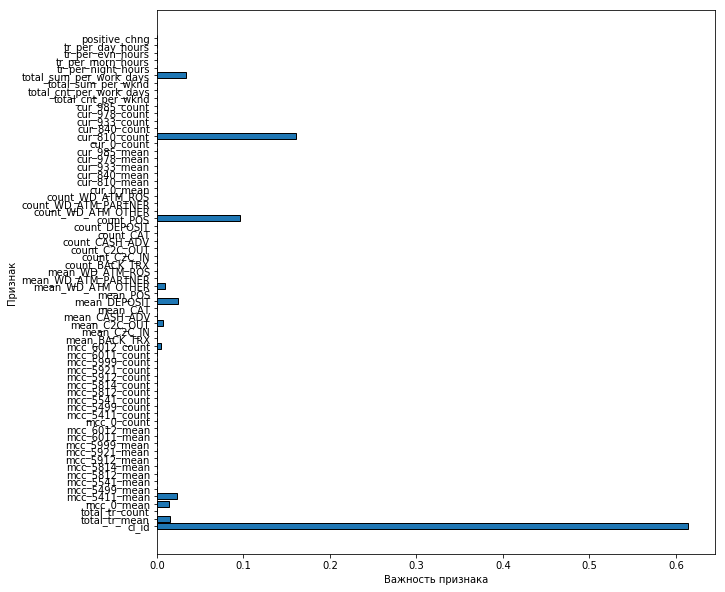

In [85]:
def plot_feature_importances_cancer(model):
    n_features = len(x.columns)
    plt.barh(range(n_features),model.feature_importances_,ec="black",align='center')
    plt.yticks(np.arange(n_features),x.columns)
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
 

plt.tight_layout()
plot_feature_importances_cancer(tree)

Попробуем применить модель на основе ансамблей моделей. Такие модели требуют больше времени на обучение, однако, дают высокий результат.

In [104]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,random_state=0)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Ансамбли деревьев  дали прибавку в точности к резульататм логистической регрессии.

In [105]:
print('Правильность на тренировочном наборе {:.2f}'.format(forest.score(X_train,y_train)))
print('Правильность на тестовом наборе {:.2f}'.format(forest.score(X_test,y_test)))

Правильность на тренировочном наборе 1.00
Правильность на тестовом наборе 0.75


In [106]:
from sklearn.ensemble import GradientBoostingClassifier

In [138]:
grbt = GradientBoostingClassifier(random_state=0,max_depth=3, learning_rate=0.1)
grbt.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

Градиентный бустинг величил точность модели на 1 процент:

In [139]:
print('Правильность на тренировочном наборе {:.2f}'.format(grbt.score(X_train,y_train)))
print('Правильность на тестовом наборе {:.2f}'.format(grbt.score(X_test,y_test)))

Правильность на тренировочном наборе 0.82
Правильность на тестовом наборе 0.75


Можно видеть, что практически все модели дают не очень хороший результат. Как основная причина этого может быть слишком большое количество нерелевантных признаков в модели, необходимо провести более тщательный отбор признаков.